In [8]:
# Importing Libraries 
import pandas as pd
import numpy as np
import warnings
import re
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
from html.parser import HTMLParser
import nltk
#nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
# Loading Data
df_train = pd.read_csv("train.csv")
print(df_train.shape)
df_train.head()

(7274, 3)


,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


## Finding the No of words in each tweet

In [10]:
#The basic intuition behind this is that generally, the negative sentiments contain a lesser amount of words than the positive ones.
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split(" ")))
df_train[['tweet','word_count']].head(15)

,tweet,word_count
0,#sxswnui #sxsw #apple defining language of tou...,12
1,Learning ab Google doodles! All doodles should...,19
2,one of the most in-your-face ex. of stealing t...,23
3,This iPhone #SXSW app would b pretty awesome i...,19
4,Line outside the Apple store in Austin waiting...,15
5,#technews One lone dude awaits iPad 2 at Apple...,18
6,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",13
7,NU user RT @mention New #UberSocial for #iPhon...,20
8,Free #SXSW sampler on iTunes {link} #FreeMusic,7
9,I think I might go all weekend without seeing ...,15


In [11]:
df_train.head(5)

,tweet_id,tweet,sentiment,word_count
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12
1,1851,Learning ab Google doodles! All doodles should...,1,19
2,2689,one of the most in-your-face ex. of stealing t...,2,23
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19
4,3604,Line outside the Apple store in Austin waiting...,1,15


## Number of characters

In [12]:
df_train['char_count'] = df_train['tweet'].str.len() ## this also includes spaces
df_train[['tweet','char_count']].head()

,tweet,char_count
0,#sxswnui #sxsw #apple defining language of tou...,89.0
1,Learning ab Google doodles! All doodles should...,143.0
2,one of the most in-your-face ex. of stealing t...,132.0
3,This iPhone #SXSW app would b pretty awesome i...,125.0
4,Line outside the Apple store in Austin waiting...,77.0


## Average Word Length

In [13]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df_train['avg_word'] = df_train['tweet'].apply(lambda x: avg_word(x))
df_train[['tweet','avg_word']].head()

AttributeError: 'float' object has no attribute 'split'

## Number of StopWords

In [14]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_train['stopwords'] = df_train['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
df_train[['tweet','stopwords']].head()

AttributeError: 'float' object has no attribute 'split'

## Number of special characters

In [15]:
df_train['hastags'] = df_train['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df_train[['tweet','hastags']].head()

AttributeError: 'float' object has no attribute 'split'

## Number of Numeric

In [16]:
df_train['numerics'] = df_train['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df_train[['tweet','numerics']].head()

AttributeError: 'float' object has no attribute 'split'

## Number of Uppercase words

In [17]:
df_train['upper'] = df_train['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df_train[['tweet','upper']].head()

AttributeError: 'float' object has no attribute 'split'

In [18]:
html_parser = HTMLParser()

In [19]:
print(type(df_train['tweet'][0]))
df_train['tweet'] = df_train['tweet'].astype(str)
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: html_parser.unescape(x))
df_train.head(5)

<class 'str'>


,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,Learning ab Google doodles! All doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,This iPhone #SXSW app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,Line outside the Apple store in Austin waiting...


In [20]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [21]:
# remove user handles (@mention)
df_train['clean_tweet'] = np.vectorize(remove_pattern)(df_train['clean_tweet'], "@[\w]*")
df_train.head(5)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,Learning ab Google doodles! All doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,This iPhone #SXSW app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,Line outside the Apple store in Austin waiting...


In [22]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: x.lower())
df_train.head()


,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...


## Understanding of Hashtags:

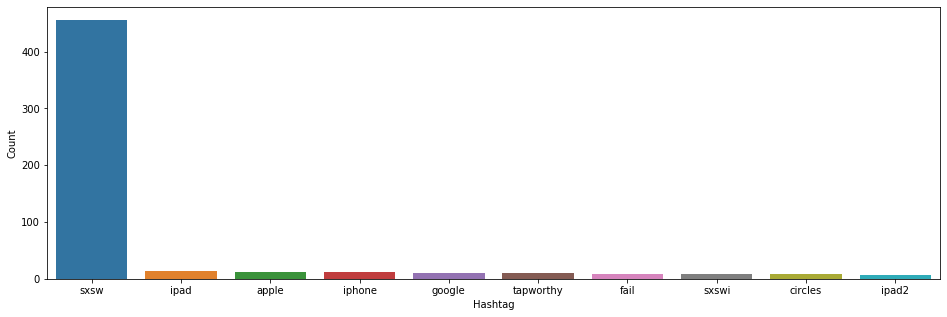

In [23]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(df_train['clean_tweet'][df_train['sentiment'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(df_train['clean_tweet'][df_train['sentiment'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

#Plotting the Hashtags
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [24]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
apostrophe_dict

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [25]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [26]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))
df_train.head(5)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...


In [27]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [28]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))
df_train.head(10)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1,18,115.0,#technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1,13,82.0,"sxsw tips, prince, npr videos, toy shopping wi..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1,20,119.0,nu user rt new #ubersocial for #iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,7,46.0,free #sxsw sampler on itunes {link} #freemusic
9,883,I think I might go all weekend without seeing ...,2,15,79.0,i think i might go all weekend without seeing ...


In [29]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}
emoticon_dict

{':)': 'happy',
 ':‑)': 'happy',
 ':-]': 'happy',
 ':-3': 'happy',
 ':->': 'happy',
 '8-)': 'happy',
 ':-}': 'happy',
 ':o)': 'happy',
 ':c)': 'happy',
 ':^)': 'happy',
 '=]': 'happy',
 '=)': 'happy',
 '<3': 'happy',
 ':-(': 'sad',
 ':(': 'sad',
 ':c': 'sad',
 ':<': 'sad',
 ':[': 'sad',
 '>:[': 'sad',
 ':{': 'sad',
 '>:(': 'sad',
 ':-c': 'sad',
 ':-< ': 'sad',
 ':-[': 'sad',
 ':-||': 'sad'}

In [30]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
df_train.head(10)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,#sxswnui #sxsw #apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles! all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in-your-face ex. of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone #sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1,18,115.0,#technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1,13,82.0,"sxsw tips, prince, npr videos, toy shopping wi..."
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1,20,119.0,nu user rt new #ubersocial for #iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,7,46.0,free #sxsw sampler on itunes {link} #freemusic
9,883,I think I might go all weekend without seeing ...,2,15,79.0,i think i might go all weekend without seeing ...


In [31]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
df_train.head(10)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,sxswnui sxsw apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in your face ex of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1,18,115.0,technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1,13,82.0,sxsw tips prince npr videos toy shopping wi...
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1,20,119.0,nu user rt new ubersocial for iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,7,46.0,free sxsw sampler on itunes link freemusic
9,883,I think I might go all weekend without seeing ...,2,15,79.0,i think i might go all weekend without seeing ...


In [32]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
df_train.head(10)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,sxswnui sxsw apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in your face ex of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1,18,115.0,technews one lone dude awaits ipad 2 at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1,13,82.0,sxsw tips prince npr videos toy shopping wi...
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1,20,119.0,nu user rt new ubersocial for iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,7,46.0,free sxsw sampler on itunes link freemusic
9,883,I think I might go all weekend without seeing ...,2,15,79.0,i think i might go all weekend without seeing ...


In [33]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
df_train.head(10)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,sxswnui sxsw apple defining language of tou...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles all doodles should...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in your face ex of stealing t...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone sxsw app would b pretty awesome i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...
5,966,#technews One lone dude awaits iPad 2 at Apple...,1,18,115.0,technews one lone dude awaits ipad at apple...
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1,13,82.0,sxsw tips prince npr videos toy shopping wi...
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1,20,119.0,nu user rt new ubersocial for iphone now in...
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,7,46.0,free sxsw sampler on itunes link freemusic
9,883,I think I might go all weekend without seeing ...,2,15,79.0,i think i might go all weekend without seeing ...


In [34]:
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
df_train.head()

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,sxswnui sxsw apple defining language of touch ...
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles all doodles should ...
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in your face ex of stealing th...
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone sxsw app would pretty awesome if i...
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...


In [35]:
text = df_train['clean_tweet'][0:10].apply(lambda x: str(TextBlob(x).correct()))
text

0    sxswnui saw apple defining language of touch w...
1    learning ab goose doubles all doubles should b...
2    one of the most in your face ex of stealing th...
3    this phone saw pp would pretty awesome if it d...
4    line outside the apple store in austin waiting...
5    technews one lone due awaits pad at apple saw ...
6    saw tips prince nor video toy shopping with zu...
7    no user it new ubersocial for phone now in the...
8             free saw simpler on tunes link freemusic
9    think might go all weekend without seeing the ...
Name: clean_tweet, dtype: object

In [36]:
# Creating token for the clean tweets
df_train['tweet_token'] = df_train['clean_tweet'].apply(lambda x: word_tokenize(x))

## Fully formated tweets & there tokens
df_train.head(5)

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet,tweet_token
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,sxswnui sxsw apple defining language of touch ...,"[sxswnui, sxsw, apple, defining, language, of,..."
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles all doodles should ...,"[learning, ab, google, doodles, all, doodles, ..."
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in your face ex of stealing th...,"[one, of, the, most, in, your, face, ex, of, s..."
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone sxsw app would pretty awesome if i...,"[this, iphone, sxsw, app, would, pretty, aweso..."
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...,"[line, outside, the, apple, store, in, austin,..."


In [37]:
#df_train.loc[df_train['clean_tweet']=='apple']

In [38]:
#res = [apple for apple in df_train['tweet_token'] if(apple in df_train['tweet_token'])]

In [39]:
tweet_data=df_train['tweet_token']

In [40]:
df_train['apple']=df_train['clean_tweet'].str.find('apple'or 'ipad')

In [41]:
brand_apple = (df_train[df_train['apple'] >0] 
          .groupby(['tweet_id','clean_tweet'])['sentiment']
          .sum().reset_index().fillna(0) 
          .set_index('tweet_id')) 

In [42]:
brand_apple.shape

(1497, 2)

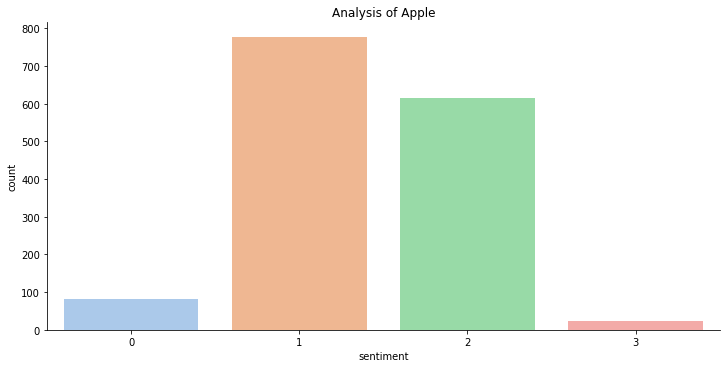

In [90]:
sns.catplot(x="sentiment", data=brand_apple, kind="count", size=5, aspect=2, palette="pastel")
plt.title('Analysis of Apple')
plt.show();

In [44]:
df_train['sxsw']=df_train['clean_tweet'].str.find('sxsw')

In [45]:
sxsw_data = (df_train[df_train['sxsw'] >0] 
          .groupby(['tweet_id','clean_tweet'])['sentiment']
          .sum().reset_index().fillna(0) 
          .set_index('tweet_id')) 

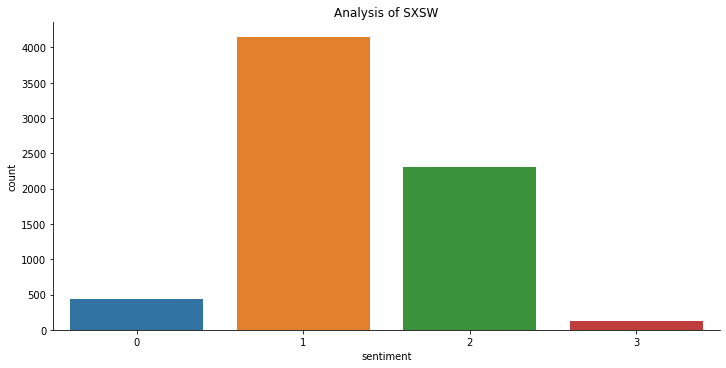

In [77]:
sns.catplot(x="sentiment", data=sxsw_data, kind="count", size=5, aspect=2)
plt.title('Analysis of SXSW')
plt.show();

In [47]:
df_train['google']=df_train['clean_tweet'].str.find('google')

In [48]:
google_data = (df_train[df_train['google'] >2] 
          .groupby(['tweet_id','clean_tweet'])['sentiment']
          .sum().reset_index().fillna(0) 
          .set_index('tweet_id')) 

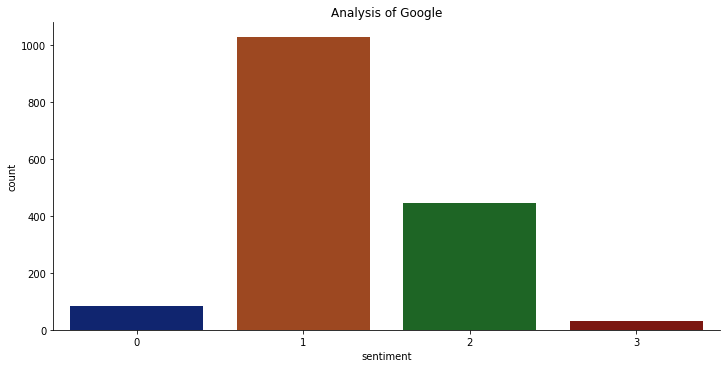

In [80]:
sns.catplot(x="sentiment", data=google_data, kind="count", size=5, aspect=2, palette="dark")
plt.title('Analysis of Google')
plt.show();

## Scatter Plot

In [50]:

# import statements
#from sklearn.datasets import make_blobs
#import numpy as np
#import matplotlib.pyplot as plt
# create blobs
#df_train = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
#points = df_train[0]
# create scatter plot
#plt.scatter(df_train['tweet_token'][0][:,0], data[0][:,1], c=data[1], cmap='viridis')
#plt.xlim(-15,15)
#plt.ylim(-15,15)

In [51]:
#corrmat = df_train(['clean_tweet']).corr() 
  
#cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
#plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
  
#cg 

In [52]:
# Loading Libraries 
#from nltk.tag import DefaultTagger 
  
# Defining Tag 
#tagging = DefaultTagger('NN') 
  
# Tagging 
#tagging.tag(df_train['tweet_token']) 

## Segregation of cant Say:

In [65]:
sentiment_cs = (df_train[df_train['sentiment'] ==3] 
          .groupby(['tweet_id','clean_tweet'])
          .sum().reset_index().fillna(0) 
          .set_index('tweet_id')) 

In [66]:
print(sentiment_cs)

                                                clean_tweet  sentiment  \
tweet_id                                                                 
90        thanks to for publishing the news of new medic...          3   
341       the queue at the apple store in austin is four...          3   
368       hope it has it is better than wave rt buzz is ...          3   
413       syd sxsw crew your iphone extra juice pods hav...          3   
488       gave into extreme temptation at sxsw and bough...          3   
...                                                     ...        ...   
9020      it has it is funny watching room full of peopl...          3   
9032       yeah we have google has nothing on us happy sxsw          3   
9037      yes the google presentation was not exactly wh...          3   
9058      do you know what apple is really good at makin...          3   
9066      how much you want to bet apple is disproportio...          3   

          word_count  char_count  app

In [67]:
#get the subjectivity(how subjetive text is)
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#polarity(How positive or negative text is)
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

sentiment_cs['subjectivity'] = sentiment_cs['clean_tweet'].apply(getSubjectivity)
sentiment_cs['polarity'] = sentiment_cs['clean_tweet'].apply(getPolarity)

In [68]:
sentiment_cs

,clean_tweet,sentiment,word_count,char_count,apple,sxsw,google,subjectivity,polarity
tweet_id,,,,,,,,,
90,thanks to for publishing the news of new medic...,3,20,116.0,-1,61,-1,0.218182,1.121212e-01
341,the queue at the apple store in austin is four...,3,15,78.0,17,71,-1,0.650000,-3.250000e-01
368,hope it has it is better than wave rt buzz is ...,3,18,113.0,-1,94,46,0.283333,2.666667e-01
413,syd sxsw crew your iphone extra juice pods hav...,3,11,63.0,-1,4,-1,0.100000,0.000000e+00
488,gave into extreme temptation at sxsw and bough...,3,12,70.0,-1,32,-1,1.000000,-1.250000e-01
...,...,...,...,...,...,...,...,...,...
9020,it has it is funny watching room full of peopl...,3,28,137.0,-1,132,-1,0.597222,1.986111e-01
9032,yeah we have google has nothing on us happy sxsw,3,13,67.0,-1,44,13,1.000000,8.000000e-01
9037,yes the google presentation was not exactly wh...,3,13,81.0,-1,63,8,0.250000,-1.250000e-01


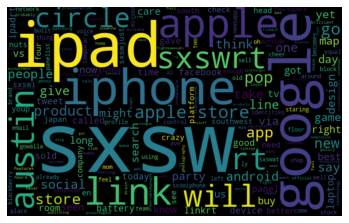

In [69]:
allWords=''.join([twts for twts in sentiment_cs['clean_tweet'] ])
wordCloud = WordCloud(width = 800, height=500, random_state=21,max_font_size=200).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [70]:
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score==0:
        return 'Neutral'
    else:
        return 'Positive'
sentiment_cs['Sentiments'] = sentiment_cs['polarity'].apply(getAnalysis)

In [71]:
sentiment_cs.head()

,clean_tweet,sentiment,word_count,char_count,apple,sxsw,google,subjectivity,polarity,Sentiments
tweet_id,,,,,,,,,,
90,thanks to for publishing the news of new medic...,3,20,116.0,-1,61,-1,0.218182,0.112121,Positive
341,the queue at the apple store in austin is four...,3,15,78.0,17,71,-1,0.650000,-0.325000,Negative
368,hope it has it is better than wave rt buzz is ...,3,18,113.0,-1,94,46,0.283333,0.266667,Positive
413,syd sxsw crew your iphone extra juice pods hav...,3,11,63.0,-1,4,-1,0.100000,0.000000,Neutral
488,gave into extreme temptation at sxsw and bough...,3,12,70.0,-1,32,-1,1.000000,-0.125000,Negative


In [72]:
ptweets=sentiment_cs[sentiment_cs.Sentiments=='Positive']
ptweets=ptweets['clean_tweet']
ptweets.head()
round((ptweets.shape[0]/sentiment_cs.shape[0])*100, 1)

40.0

In [74]:
ntweets=sentiment_cs[sentiment_cs.Sentiments=='Negative']
ntweets=ntweets['clean_tweet']
ntweets.head()
round((ntweets.shape[0]/sentiment_cs.shape[0])*100, 1)

15.2

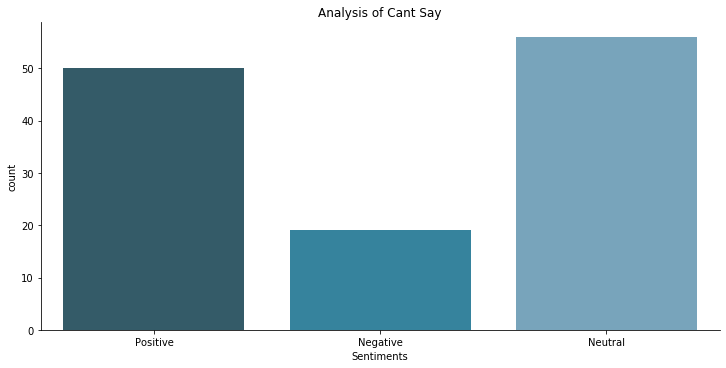

In [75]:
sns.catplot(x="Sentiments", data=sentiment_cs, kind="count", size=5, aspect=2, palette="PuBuGn_d")
plt.title('Analysis of Cant Say')
plt.show();

In [63]:
df_train.head()

,tweet_id,tweet,sentiment,word_count,char_count,clean_tweet,tweet_token,apple,sxsw,google
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,12,89.0,sxswnui sxsw apple defining language of touch ...,"[sxswnui, sxsw, apple, defining, language, of,...",13,0,-1
1,1851,Learning ab Google doodles! All doodles should...,1,19,143.0,learning ab google doodles all doodles should ...,"[learning, ab, google, doodles, all, doodles, ...",-1,127,12
2,2689,one of the most in-your-face ex. of stealing t...,2,23,132.0,one of the most in your face ex of stealing th...,"[one, of, the, most, in, your, face, ex, of, s...",71,66,-1
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,19,125.0,this iphone sxsw app would pretty awesome if i...,"[this, iphone, sxsw, app, would, pretty, aweso...",-1,12,-1
4,3604,Line outside the Apple store in Austin waiting...,1,15,77.0,line outside the apple store in austin waiting...,"[line, outside, the, apple, store, in, austin,...",17,64,-1


## Common Word Removal

In [ ]:
freq = pd.Series(' '.join(df_train['clean_tweet']).split()).value_counts()[:10]


In [ ]:
freq = list(freq.index)
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df_train['clean_tweet'].head()

## Rarer word Removal

In [ ]:
freq = pd.Series(' '.join(df_train['clean_tweet']).split()).value_counts()[-10:]

In [ ]:
freq = list(freq.index)
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df_train['clean_tweet'].head()

## Spelling correction of words to reduce multiple copies of words

In [ ]:
from textblob import TextBlob
df_train['clean_tweet'][:5].apply(lambda x: str(TextBlob(x).correct()))

# Advance Text Processing

In [ ]:
TextBlob(df_train['clean_tweet'][0]).ngrams(2)

In [ ]:
tf1 = (df_train['clean_tweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

In [ ]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(df_train.shape[0]/(len(df_train[df_train['clean_tweet'].str.contains(word)])))

tf1

In [ ]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1
#TO panalise the words like cant ... use tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df_train['clean_tweet'])

In [ ]:
print(train_vect)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
df_train_bow = bow.fit_transform(df_train['clean_tweet'])

In [ ]:
print(df_train_bow)

In [ ]:
sns.catplot(x="Words", data=df_train['clean_tweet'], kind="count",main="sxsw", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();
sns.barplot(beside=TRUE,xlab = "Words",ylab = "Corr",col = "blue",main = "sxsw",border = "black")

In [136]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from gensim.models.ldamulticore import LdaMulticore

from pprint import pprint
vectorizer=CountVectorizer(stop_words='english',max_features=30000)

n_topics=10

topics=vectorizer.fit_transform(df_train['tweet'])
ldamodel = LdaMulticore(corpus=doc_term_matrix, num_topics=5,id2word=dictionary, random_state=20, passes=30, workers= 12)
# fit and transform 'news' 
pprint(ldamodel.print_topics())

[(0,
  '0.089*"sxsw" + 0.040*"link" + 0.023*"ipad" + 0.021*"iphone" + '
  '0.020*"android" + 0.019*"google" + 0.018*"rt" + 0.016*"app" + 0.014*"new" + '
  '0.008*"check"'),
 (1,
  '0.071*"sxsw" + 0.040*"iphone" + 0.031*"link" + 0.031*"app" + 0.024*"rt" + '
  '0.011*"austin" + 0.009*"free" + 0.008*"code" + 0.008*"ipad" + 0.007*"best"'),
 (2,
  '0.094*"sxsw" + 0.061*"link" + 0.056*"apple" + 0.043*"store" + 0.036*"rt" + '
  '0.033*"google" + 0.027*"ipad" + 0.019*"launch" + 0.019*"circle" + '
  '0.019*"austin"'),
 (3,
  '0.087*"sxsw" + 0.049*"ipad" + 0.029*"rt" + 0.025*"google" + 0.019*"link" + '
  '0.012*"iphone" + 0.006*"map" + 0.006*"people" + 0.006*"design" + '
  '0.005*"win"'),
 (4,
  '0.084*"sxsw" + 0.028*"link" + 0.023*"google" + 0.021*"iphone" + 0.019*"rt" '
  '+ 0.012*"ipad" + 0.010*"apple" + 0.010*"free" + 0.008*"party" + '
  '0.008*"time"')]


In [137]:
ldamodel.get_document_topics(doc_term_matrix,minimum_probability=0)

In [130]:
[ldamodel.get_document_topic(items,minimum_probability=0) for item in doc_term_matrix[:5]]

AttributeError: 'LdaMulticore' object has no attribute 'get_document_topic'

In [ ]:
# empty dictionary to store topic number and top 10 words for every topic 
topic_lda={}

# loop over every topic
for i, topic in enumerate(ldamodel.components_):
    key = "Topic {}".format(i)
    value = [(vectorizer.get_feature_names()[i] + '*' + str(topic[i])) for i in topic.argsort()[:-11:-1]]
    topic_lsa[key] = ' + '.join(value)

# pretty print topics
pprint(topic_lsa)


In [138]:
import string


custom = list(stop)+list(punctuation)


exclude = set(string.punctuation)

In [139]:
import pyLDAvis
from gensim import corpora

import pyLDAvis.gensim 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in custom])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemmatizer.lemmatize(word) for word in punc_free.split())
    return normalized

list_of_docs = df_train["clean_tweet"].tolist()
print(list_of_docs)

['sxswnui sxsw apple defining language of touch with different dialects becoming smaller', 'learning ab google doodles all doodles should be light funny innovative with exceptions for significant occasions googledoodle sxsw', 'one of the most in your face ex of stealing the show in yrs rt at sxsw apple schools the mkt experts link', 'this iphone sxsw app would pretty awesome if it did not crash every mins during extended browsing fuckit illmakeitwork', 'line outside the apple store in austin waiting for the new ipad sxsw link', 'technews one lone dude awaits ipad at apple sxsw store link tech news apple ipad sxsw tablets tech', 'sxsw tips prince npr videos toy shopping with zuckerberg link sxsw ipad', 'nu user rt new ubersocial for iphone now in the app store includes uberguide to sxsw sponsored by mashable', 'free sxsw sampler on itunes link freemusic', 'think might go all weekend without seeing the same ipad case twice sxsw', 'rt official sxsw app sxsw go bit ly hmiiga android iphone

In [140]:

doc_clean = [clean(doc).split() for doc in list_of_docs]
dictionary = corpora.Dictionary(doc_clean)
dictionary

In [141]:
# Creating the corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

C:\Users\PIYUSHA\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.221666 -0.025899       1        1  31.948048
3     -0.029613  0.100903       2        1  22.732973
0     -0.035341 -0.006204       3        1  21.389912
4     -0.060475  0.052808       4        1  14.451549
1     -0.096238 -0.121608       5        1   9.477522, topic_info=    Category         Freq    Term        Total  loglift  logprob
49   Default  1126.000000   store  1126.000000  30.0000  30.0000
0    Default  1720.000000   apple  1720.000000  29.0000  29.0000
40   Default  1172.000000  iphone  1172.000000  28.0000  28.0000
32   Default   616.000000     app   616.000000  27.0000  27.0000
158  Default   499.000000  launch   499.000000  26.0000  26.0000
..       ...          ...     ...          ...      ...      ...
14    Topic5    49.545902  google  1932.761963  -1.3076  -5.0363
301   Topic5    27.025537     win   189.000793   0.4113  -5.6424
215   Topic5    23.549860   check   193.042847   0.2525  -5.7801
47    Topic5    24.448145     new   789.852661  -1.1190  -5.7426
294   Topic5    22.422020    time   225.774414   0.0468  -5.8291

[365 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
968       4  0.033068      access
968       5  0.958964      access
467       5  0.893052     account
969       5  0.970180    acoustic
3000      2  0.913494      afford
...     ...       ...         ...
1535      2  0.927525     yourmom
4389      2  0.876991       yoyou
3428      3  0.936873  zazzlesxsw
3428      4  0.052049  zazzlesxsw
1998      5  0.909471         zlf

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])